In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [5]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Liar Dataset

In [6]:
# Load data
liar_df = pd.read_csv('Liar_Dataset.csv')

In [7]:
# Function to clean statment
def clean_text(text):
    """
    Clean and normalize text data
    """
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

#Function to tokenize
def preprocess_text(text):
    """
    Tokenize and remove stopwords
    """
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

## Cleaning & Preprocessing

In [8]:
# Apply cleaning
liar_df['statement_clean'] = liar_df['statement'].apply(clean_text)

# Apply preprocessing
liar_df['statement_processed'] = liar_df['statement_clean'].apply(preprocess_text)

# Apply encoding
label_encoder = LabelEncoder()
liar_df['label_encoded'] = label_encoder.fit_transform(liar_df['label'])

### Handling Null Values


In [9]:
# Handle missing values
liar_df["speaker's job title"].fillna("Unknown", inplace=True)
liar_df["state info"].fillna("Unknown", inplace=True)
liar_df["venue"].fillna("Unknown", inplace=True)

/tmp/ipython-input-3756403148.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  liar_df["speaker's job title"].fillna("Unknown", inplace=True)
/tmp/ipython-input-3756403148.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [10]:
liar_df.isnull().sum()

,0
[ID].json,0
label,0
statement,0
subject(s),0
speaker,0
speaker's job title,0
state info,0
party affiliation,0
barely true counts,0
false counts,0


### Encoding Metadata

In [11]:
# Encode categorical metadata
speaker_encoder = LabelEncoder()
subject_encoder = LabelEncoder()
speaker_job_title_encoder = LabelEncoder()
state_encoder = LabelEncoder()
party_encoder = LabelEncoder()
venue_encoder = LabelEncoder()

liar_df['speaker_encoded'] = speaker_encoder.fit_transform(liar_df['speaker'])
liar_df['subject_encoded'] = subject_encoder.fit_transform(liar_df['subject(s)'])
liar_df['speaker_job_encoded'] = speaker_job_title_encoder.fit_transform(liar_df["speaker's job title"])
liar_df['state_encoded'] = state_encoder.fit_transform(liar_df['state info'])
liar_df['party_encoded'] = party_encoder.fit_transform(liar_df['party affiliation'])
liar_df['venue_encoded'] = venue_encoder.fit_transform(liar_df['venue'])

## TF-IDF Vectorization

In [12]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,      # Limit to top 5000 features
    ngram_range=(1, 2),     # Unigrams and bigrams
    min_df=2,               # Ignore terms that appear in fewer than 2 documents
    max_df=0.8              # Ignore terms that appear in more than 80% of documents
)

# Fit on LIAR training data
X_text_tfidf = tfidf_vectorizer.fit_transform(liar_df['statement_processed'])

In [13]:
from scipy.sparse import hstack

# Get metadata as array
metadata_features = liar_df[['speaker_encoded', 'subject_encoded',
                             'speaker_job_encoded', 'state_encoded', 'party_encoded',
                             'venue_encoded']].values

# Combine TF-IDF with metadata
X_combined = hstack([X_text_tfidf, metadata_features])

print(f"Text features shape: {X_text_tfidf.shape}")
print(f"Metadata features shape: {metadata_features.shape}")
print(f"Combined features shape: {X_combined.shape}")

Text features shape: (12787, 5000)
Metadata features shape: (12787, 6)
Combined features shape: (12787, 5006)


## Training & Split

In [14]:
from sklearn.model_selection import train_test_split

# LIAR dataset
y = liar_df['label_encoded'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X_combined, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (8950, 5006)
Validation set: (1918, 5006)
Test set: (1919, 5006)


In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

### Decision Tree

Decision Tree - Validation Set Performance:
Accuracy: 0.2456

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.24      0.25       376
           1       0.20      0.05      0.07       308
           2       0.22      0.03      0.06       315
           3       0.23      0.40      0.29       394
           4       0.24      0.49      0.33       368
           5       0.46      0.13      0.21       157

    accuracy                           0.25      1918
   macro avg       0.27      0.22      0.20      1918
weighted avg       0.25      0.25      0.21      1918



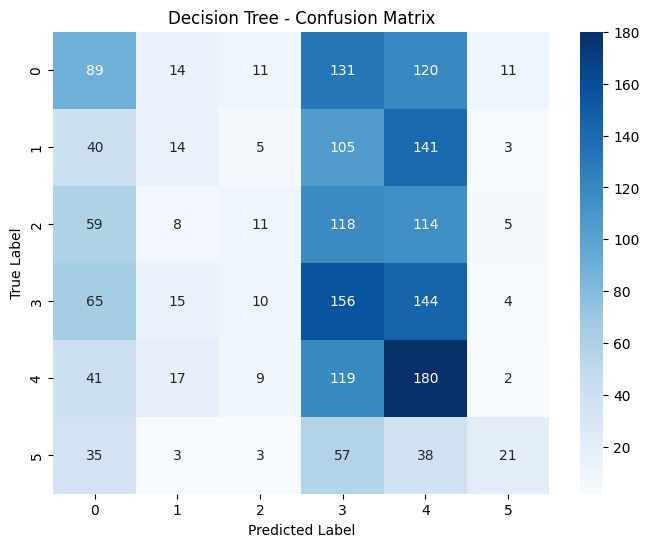

In [16]:
# Train a simple decision tree
dt_model = DecisionTreeClassifier(
    max_depth=10,
    random_state=42
)

# Fit on training data
dt_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = dt_model.predict(X_val)

# Evaluate
print("Decision Tree - Validation Set Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Top 20 Most Important Features:
                  feature  importance
5000              speaker    0.163146
5004    party affiliation    0.077873
5005                venue    0.058329
5002  speaker's job title    0.047103
5001           subject(s)    0.046437
5003           state info    0.031791
3091              percent    0.029094
3808                 says    0.025418
4521                today    0.024458
2156                 jobs    0.018434
3916                scott    0.018421
1374                every    0.017115
4886            wisconsin    0.015739
3274            president    0.013549
4385                taxes    0.012287
92        africanamerican    0.011436
2846            obamacare    0.011344
258              attorney    0.011325
2731               nearly    0.011122
3411                  put    0.010634


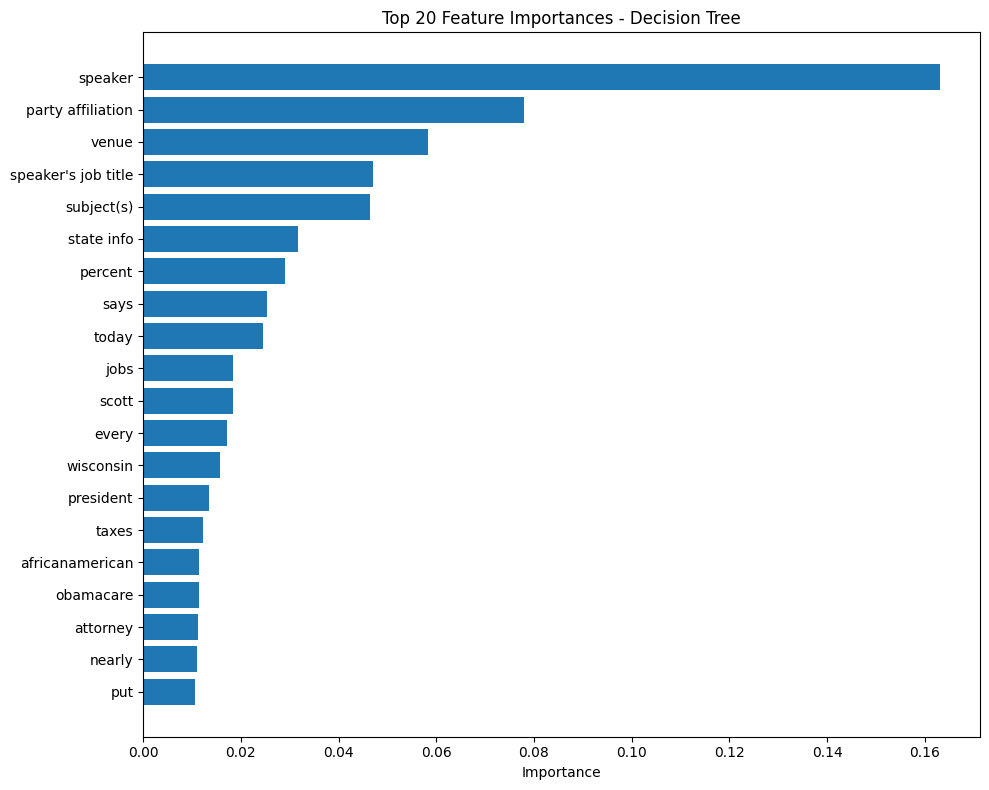

In [17]:
# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out().tolist()
feature_names.extend(['speaker', 'subject(s)',"speaker's job title", 'state info', 'party affiliation', 'venue'])

# Get feature importances
importances = dt_model.feature_importances_

# Create DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Show top 20 most important features
print("\nTop 20 Most Important Features:")
print(feature_importance_df.head(20))

# Visualize
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(20)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Random Forest

Training Random Forest...

Random Forest - Validation Set Performance:
Accuracy: 0.2289

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.21      0.24       376
           1       0.12      0.00      0.01       308
           2       0.43      0.03      0.05       315
           3       0.21      0.72      0.32       394
           4       0.27      0.17      0.21       368
           5       1.00      0.01      0.01       157

    accuracy                           0.23      1918
   macro avg       0.38      0.19      0.14      1918
weighted avg       0.32      0.23      0.16      1918



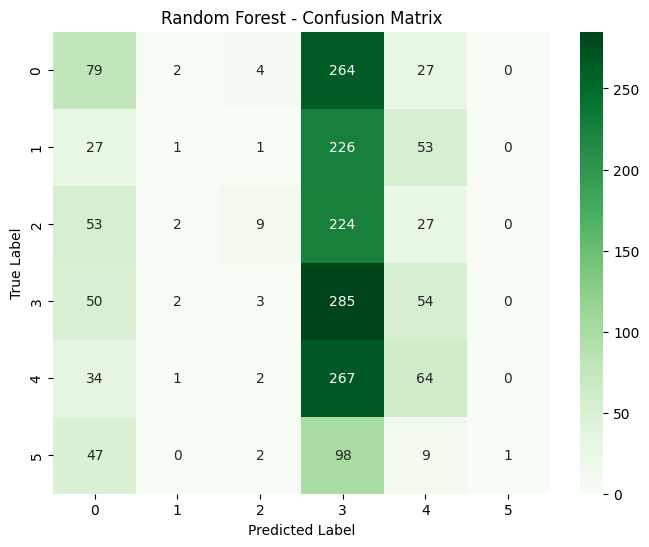

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Fit
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# Predict
y_val_pred_rf = rf_model.predict(X_val)

# Evaluate
print("\nRandom Forest - Validation Set Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Hyperparameter Tuning using GridSearchCV

In [19]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [50, 100, 200]
}

# Grid search
print("Starting Grid Search (this may take a while)...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,                    # 3-fold cross-validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best parameters
print("\nBest Parameters:")
print(grid_search.best_params_)
print(f"\nBest Cross-Validation Score: {grid_search.best_score_:.4f}")

# Use best model
best_rf_model = grid_search.best_estimator_

# Evaluate on validation set
y_val_pred_best = best_rf_model.predict(X_val)
print(f"\nBest Model Validation Accuracy: {accuracy_score(y_val, y_val_pred_best):.4f}")

Starting Grid Search (this may take a while)...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best Parameters:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Best Cross-Validation Score: 0.2545

Best Model Validation Accuracy: 0.2669


In [20]:
# Train model with TEXT ONLY (no metadata)
rf_text_only = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

# Use only TF-IDF features (not X_combined)
rf_text_only.fit(X_train[:, :5000], y_train)  # First 5000 columns are text features
y_val_pred_text = rf_text_only.predict(X_val[:, :5000])

print("Text Only Model:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_text):.4f}")

print("\nText + Metadata Model:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_rf):.4f}")

print(f"\nImprovement from adding metadata: {(accuracy_score(y_val, y_val_pred_rf) - accuracy_score(y_val, y_val_pred_text))*100:.2f}%")

Text Only Model:
Accuracy: 0.2211

Text + Metadata Model:
Accuracy: 0.2289

Improvement from adding metadata: 0.78%


## Evaluation

FINAL TEST SET PERFORMANCE
Accuracy: 0.2694

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.38      0.30       376
           1       0.29      0.15      0.20       308
           2       0.24      0.14      0.18       316
           3       0.27      0.34      0.30       394
           4       0.28      0.36      0.31       368
           5       0.63      0.11      0.18       157

    accuracy                           0.27      1919
   macro avg       0.33      0.25      0.25      1919
weighted avg       0.30      0.27      0.26      1919



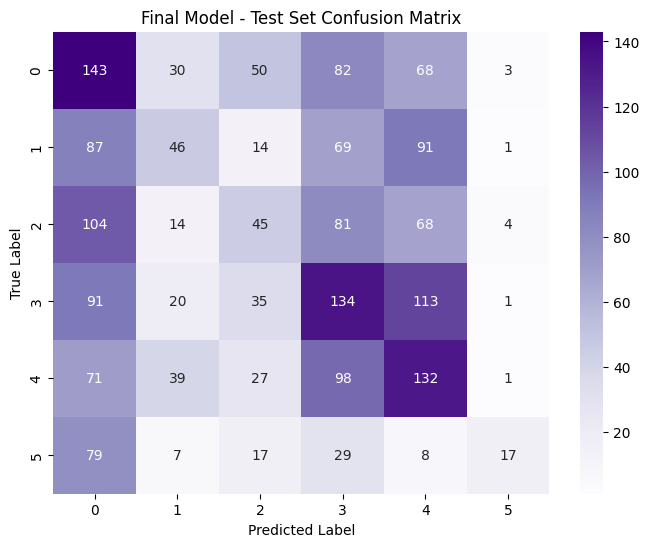

In [21]:
final_model = best_rf_model

# Predict on test set
y_test_pred = final_model.predict(X_test)

# Final evaluation
print("=" * 50)
print("FINAL TEST SET PERFORMANCE")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Purples')
plt.title('Final Model - Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ISOT Dataset

In [22]:
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

fake_df['label'] = 0
true_df['label'] = 1

isot_df = pd.concat([fake_df, true_df], ignore_index=True)

isot_df = isot_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"ISOT Dataset size: {len(isot_df)}")
print(f"\nLabel distribution:")
print(isot_df['label'].value_counts())
print(f"\nColumns: {isot_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(isot_df.head())

ISOT Dataset size: 44898

Label distribution:
label
0    23481
1    21417
Name: count, dtype: int64

Columns: ['title', 'text', 'subject', 'date', 'label']

First few rows:
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      0  
1    

## Cleaning & Preprocessing

In [23]:
def clean_text_improved(text):
    """
    Improved text cleaning that preserves more structure
    """
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s\.\,\!\?]', ' ', text)  # Keep . , ! ?
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [24]:
isot_df['combined_text'] = isot_df['title'].fillna('') + ' ' + isot_df['text'].fillna('')
isot_df['text_clean'] = isot_df['combined_text'].apply(clean_text_improved)
isot_df['text_processed'] = isot_df['text_clean'].apply(preprocess_text)

print(isot_df['text_processed'].iloc[0][:500])

ben stein calls th circuit court committed coup tat constitution st century wire says ben stein , reputable professor , pepperdine university also hollywood fame appearing tv shows films ferris bueller day made provocative statements judge jeanine pirro show recently . discussing halt imposed president trump executive order travel . stein referred judgement th circuit court washington state coup tat executive branch constitution . stein went call judges seattle political puppets judiciary politi


## TF-IDF Encoding

In [25]:
isot_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

# Transform text
print("Creating TF-IDF features...")
X_isot = isot_vectorizer.fit_transform(isot_df['text_processed'])
y_isot = isot_df['label'].values

print(f"\nISOT Feature matrix shape: {X_isot.shape}")
print(f"ISOT Labels shape: {y_isot.shape}")
print(f"Label distribution: {np.bincount(y_isot)}")

Creating TF-IDF features...

ISOT Feature matrix shape: (44898, 5000)
ISOT Labels shape: (44898,)
Label distribution: [23481 21417]


## Training & Split

In [26]:
X_isot_train, X_isot_temp, y_isot_train, y_isot_temp = train_test_split(
    X_isot,
    y_isot,
    test_size=0.3,
    random_state=42,
    stratify=y_isot
)

X_isot_val, X_isot_test, y_isot_val, y_isot_test = train_test_split(
    X_isot_temp,
    y_isot_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_isot_temp
)

print(f"ISOT Training set: {X_isot_train.shape[0]} samples ({X_isot_train.shape[0]/len(y_isot)*100:.1f}%)")
print(f"ISOT Validation set: {X_isot_val.shape[0]} samples ({X_isot_val.shape[0]/len(y_isot)*100:.1f}%)")
print(f"ISOT Test set: {X_isot_test.shape[0]} samples ({X_isot_test.shape[0]/len(y_isot)*100:.1f}%)")

ISOT Training set: 31428 samples (70.0%)
ISOT Validation set: 6735 samples (15.0%)
ISOT Test set: 6735 samples (15.0%)


### Decision Tree

Training Decision Tree on ISOT...

DECISION TREE - ISOT VALIDATION SET PERFORMANCE
Accuracy: 0.9981

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      3522
        Real       1.00      1.00      1.00      3213

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



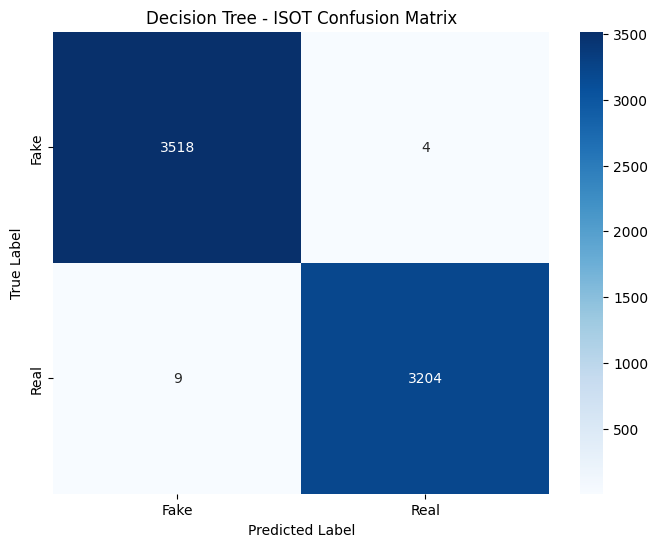

In [27]:
print("Training Decision Tree on ISOT...")
dt_isot = DecisionTreeClassifier(
    max_depth=10,
    random_state=42
)

dt_isot.fit(X_isot_train, y_isot_train)

# Predict on validation set
y_isot_val_pred_dt = dt_isot.predict(X_isot_val)

# Evaluate
print("\n" + "="*60)
print("DECISION TREE - ISOT VALIDATION SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {accuracy_score(y_isot_val, y_isot_val_pred_dt):.4f}")
print("\nClassification Report:")
print(classification_report(y_isot_val, y_isot_val_pred_dt, target_names=['Fake', 'Real']))

# Confusion Matrix
cm_dt_isot = confusion_matrix(y_isot_val, y_isot_val_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_isot, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Decision Tree - ISOT Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


TOP 20 MOST IMPORTANT FEATURES - DECISION TREE (ISOT)
                feature  importance
3724            reuters    0.971371
4437                the    0.015928
1607     featured image    0.002542
2136                 in    0.002035
4994               zika    0.000893
4648        twitter com    0.000892
3972               sept    0.000682
593                 but    0.000638
4454               this    0.000637
3266              polls    0.000511
632   candidate hillary    0.000427
4160          spokesman    0.000348
2693           meetings    0.000334
1114            declare    0.000255
690        century wire    0.000255
1564            factbox    0.000255
1027             crimes    0.000246
4152              spend    0.000239
2388           kim jong    0.000170
2410            kushner    0.000128


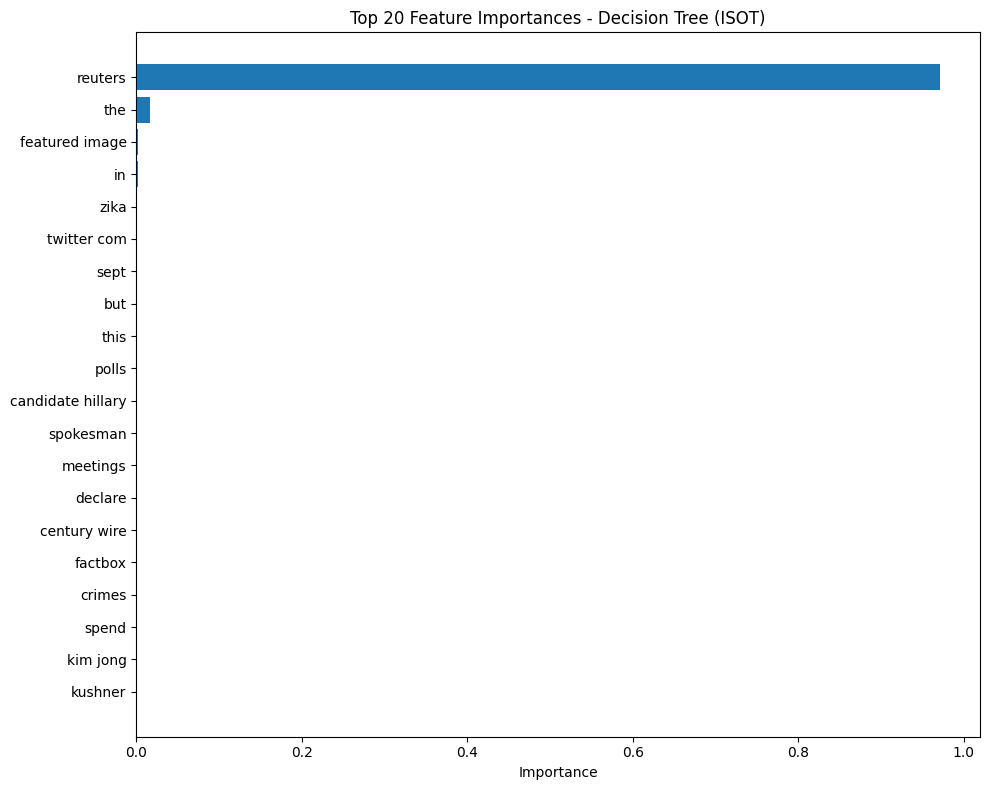

In [28]:
# Get feature importances
feature_names_isot = isot_vectorizer.get_feature_names_out().tolist()
importances_isot = dt_isot.feature_importances_

# Create DataFrame
feature_importance_isot_df = pd.DataFrame({
    'feature': feature_names_isot,
    'importance': importances_isot
}).sort_values('importance', ascending=False)

# Top 20 features
print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES - DECISION TREE (ISOT)")
print("="*60)
print(feature_importance_isot_df.head(20))

# Visualize
plt.figure(figsize=(10, 8))
top_features_isot = feature_importance_isot_df.head(20)
plt.barh(top_features_isot['feature'], top_features_isot['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Decision Tree (ISOT)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Random Forest

Training Random Forest on ISOT...

RANDOM FOREST - ISOT VALIDATION SET PERFORMANCE
Accuracy: 0.9972

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      3522
        Real       0.99      1.00      1.00      3213

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



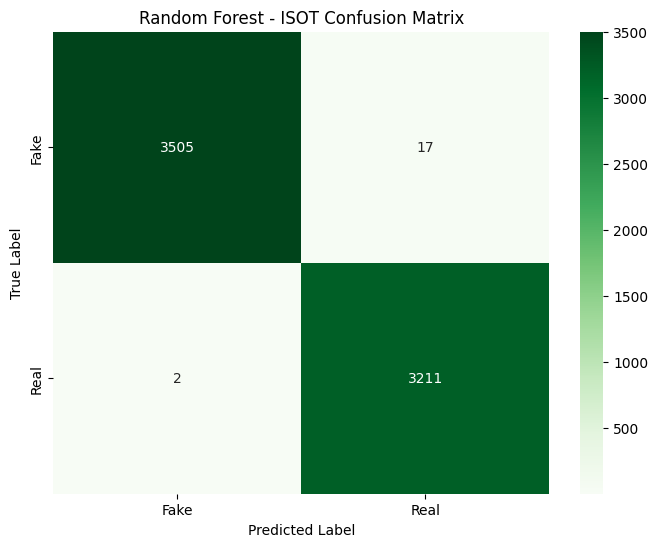

In [29]:
# Train Random Forest
print("Training Random Forest on ISOT...")
rf_isot = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_isot.fit(X_isot_train, y_isot_train)

# Predict
y_isot_val_pred_rf = rf_isot.predict(X_isot_val)

# Evaluate
print("\n" + "="*60)
print("RANDOM FOREST - ISOT VALIDATION SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {accuracy_score(y_isot_val, y_isot_val_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_isot_val, y_isot_val_pred_rf, target_names=['Fake', 'Real']))

# Confusion Matrix
cm_rf_isot = confusion_matrix(y_isot_val, y_isot_val_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_isot, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Random Forest - ISOT Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Hyperparameter Tuning using GridSearchCV

In [30]:
from sklearn.model_selection import GridSearchCV

# Reduced grid for speed
param_grid_isot = {
    'max_depth': [10, 20],
    'min_samples_split': [2, 10],
    'n_estimators': [50, 100]
}

print("Starting Grid Search for ISOT (this will take a while)...")
grid_search_isot = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_isot,
    cv=2,  # Reduced folds for speed
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search_isot.fit(X_isot_train, y_isot_train)

print("\n" + "="*60)
print("GRID SEARCH RESULTS - ISOT")
print("="*60)
print(f"Best Parameters: {grid_search_isot.best_params_}")
print(f"Best Cross-Validation Score: {grid_search_isot.best_score_:.4f}")

# Use best model
best_rf_isot = grid_search_isot.best_estimator_

# Evaluate on validation
y_isot_val_pred_best = best_rf_isot.predict(X_isot_val)
print(f"Best Model Validation Accuracy: {accuracy_score(y_isot_val, y_isot_val_pred_best):.4f}")

Starting Grid Search for ISOT (this will take a while)...
Fitting 2 folds for each of 8 candidates, totalling 16 fits

GRID SEARCH RESULTS - ISOT
Best Parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Score: 0.9978
Best Model Validation Accuracy: 0.9981


## Evaluation


FINAL TEST SET PERFORMANCE - ISOT DATASET
Accuracy: 0.9988

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      3523
        Real       1.00      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



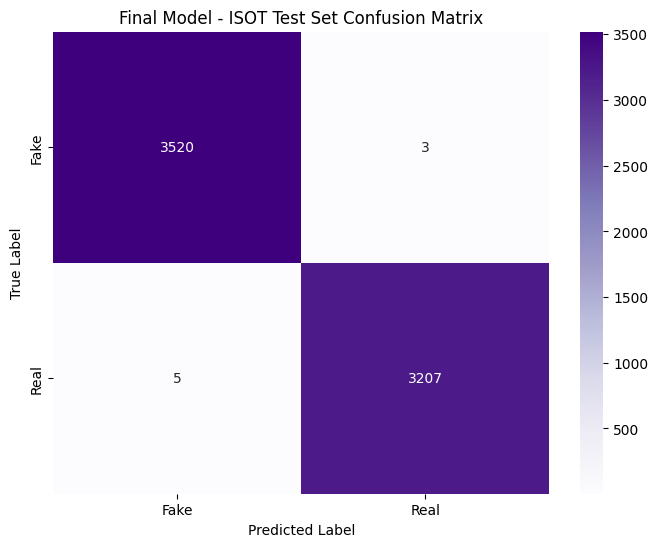

In [31]:
final_isot_model = best_rf_isot

# Predict on test set
y_isot_test_pred = final_isot_model.predict(X_isot_test)

print("\n" + "="*70)
print("FINAL TEST SET PERFORMANCE - ISOT DATASET")
print("="*70)
print(f"Accuracy: {accuracy_score(y_isot_test, y_isot_test_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_isot_test, y_isot_test_pred, target_names=['Fake', 'Real']))

# Final Confusion Matrix
cm_test_isot = confusion_matrix(y_isot_test, y_isot_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_isot, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Final Model - ISOT Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [32]:
print("\n" + "="*80)
print("MODEL COMPARISON: LIAR vs ISOT")
print("="*80)

# LIAR Results
print("\nLIAR DATASET (6-class):")
print(f"Decision Tree Validation Accuracy: 0.245")
print(f"Random Forest Validation Accuracy: 0.27")

# ISOT Results
print("\nISOT DATASET (Binary):")
print(f"Decision Tree Validation Accuracy: {accuracy_score(y_isot_val, y_isot_val_pred_dt):.4f}")
print(f"Random Forest Validation Accuracy: {accuracy_score(y_isot_test, y_isot_test_pred):.4f}")

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print("1. ISOT (binary) is easier than LIAR (6-class)")
print("2. Both datasets show Random Forest performs similarly to Decision Tree")
print("3. Models generalize to different text formats (short statements vs long articles)")


MODEL COMPARISON: LIAR vs ISOT

LIAR DATASET (6-class):
Decision Tree Validation Accuracy: 0.245
Random Forest Validation Accuracy: 0.27

ISOT DATASET (Binary):
Decision Tree Validation Accuracy: 0.9981
Random Forest Validation Accuracy: 0.9988

KEY INSIGHTS:
1. ISOT (binary) is easier than LIAR (6-class)
2. Both datasets show Random Forest performs similarly to Decision Tree
3. Models generalize to different text formats (short statements vs long articles)
